<a href="https://colab.research.google.com/github/Cucumberan/BI_ML_2024/blob/HW7/Copy_of_FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Кстати не понятно. Потому что по идее чем больше batch_size, тем дольше будет длиться одна эпоха обучения. С другой стороны, чем меньше batch_size, тем больше эпох понадобиться. С другой стороны, чем больше batch_size, тем быстрее алгоритм будет сходиться и тут нужно смотреть, что больше: выйгрышь от более быстрой сходимости алгоритма при большом batch_size или скорость обработки маленьких batch_size.

Посмотрим на какую-нибудь картинку:

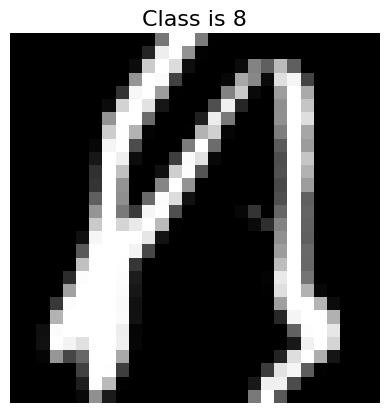

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





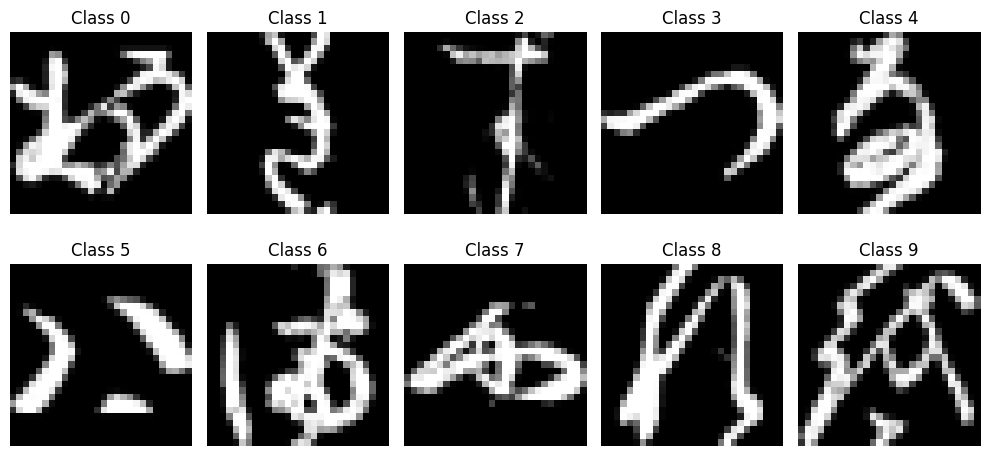

In [5]:
# Создаем пустой график с сеткой 2x5 (2 строки, 5 столбцов)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

# Инициализируем переменные для хранения индексов изображений каждого класса
class_indices = [None] * 10

# Находим индексы первого изображения каждого класса
for i in range(len(trainset)):
    img, label = trainset[i]
    if class_indices[label] is None:
        class_indices[label] = i
    if all(idx is not None for idx in class_indices):
        break

# Отображаем изображения из всех 10 классов на одном графике
for i in range(10):
    img, label = trainset[class_indices[i]]
    ax = axs[i // 5, i % 5]  # Выбираем соответствующий подграфик
    ax.imshow(img.view(28, 28).numpy(), cmap="gray")  # Отображаем изображение
    ax.set_title(f"Class {label}")  # Устанавливаем заголовок с номером класса
    ax.axis("off")  # Отключаем оси координат

plt.tight_layout()  # Выравниваем макет графика
plt.show()  # Отображаем график

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [52]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=784, out_features = 256)
        self.fc2 = nn.Linear(in_features=256,out_features = 128)
        self.fc3 = nn.Linear(in_features=128, out_features = 10)
        self.relu = nn.ReLU()


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28*28)  # Преобразуем входной тензор в плоский вектор
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [7]:
trainset
image, label = trainset[0]
image.shape

torch.Size([1, 28, 28])

In [8]:
my_neural_net = FCNet()

In [9]:
for param in my_neural_net.parameters():
    print(param.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([10, 128])
torch.Size([10])


Сколько обучаемых параметров у вашей модели (весов и смещений)?



**Ответ:** размер картинок такой же, как был на консультации (28 x 28). Соответственно в первом слое 784x256 весов и 246 смещений. На втором слое 128x246 весов и 128 смещений и на третьем слое 10X128 весов и 10 смещений. **Всего 200840 обучаемых параметров.**


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [10]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [53]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

Значение `accuracy` на тестовой выборке 0.897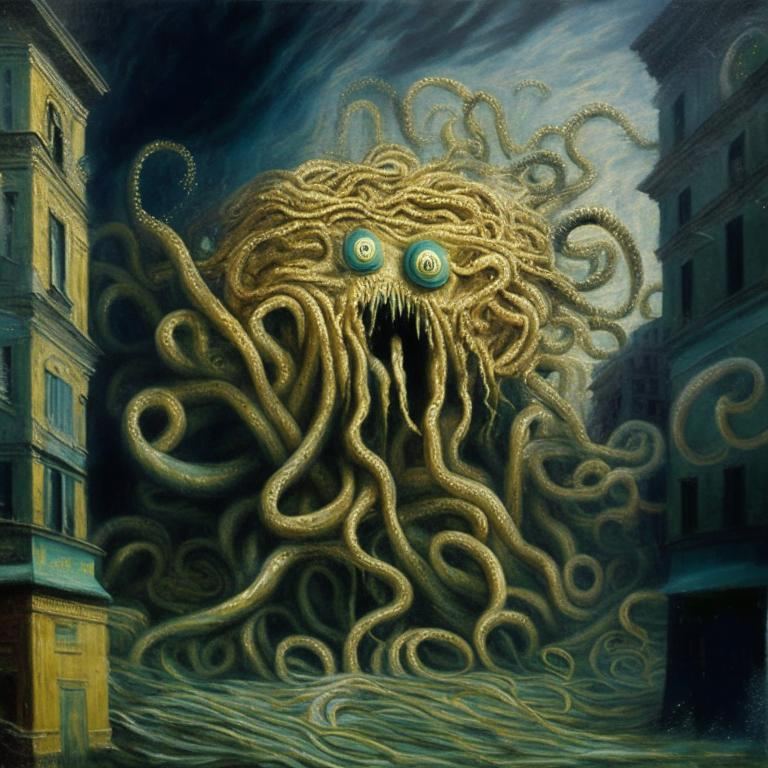

In [54]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # 1. Получаем батч тренировочных картинок
        optimizer.zero_grad() # 2. чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # 3. делаем предсказания
        loss = loss_function(outputs, labels) # 4. считаем лосс
        loss.backward() # 5. считаем градиенты
        optimizer.step() # 6. делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.6908
Epoch=2 loss=0.3024
Epoch=3 loss=0.2238
Epoch=4 loss=0.1733
Epoch=5 loss=0.1380
Epoch=6 loss=0.1115
Epoch=7 loss=0.0901
Epoch=8 loss=0.0731
Epoch=9 loss=0.0592
Epoch=10 loss=0.0476
CPU times: user 29 s, sys: 2.51 s, total: 31.5 s
Wall time: 2min 17s


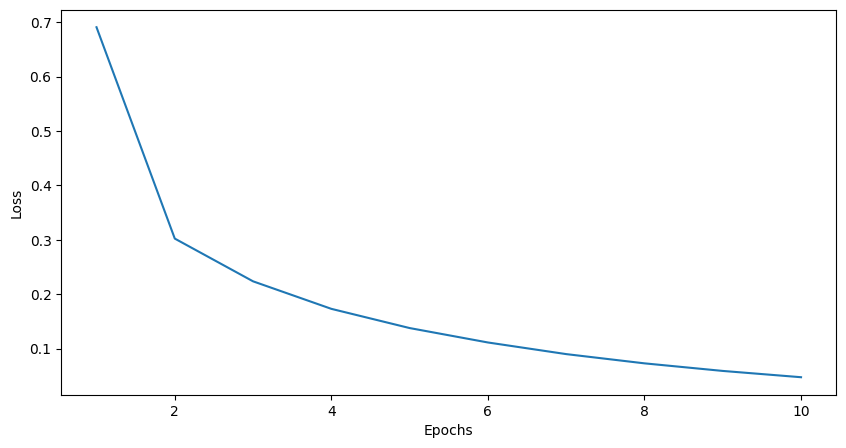

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot([i+1 for i in range(n_epochs)], loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [55]:
get_accuracy(fc_net, testloader)

0.897

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
trainset



Dataset KMNIST
    Number of datapoints: 60000
    Root location: ./KMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [ ]:
# Проверка размера датасета
print("Number of datapoints:", len(trainset))

# Проверка типа объекта внутри датасета
sample_data = trainset[0]
print("Type of the first object in the dataset:", type(sample_data))
print("Размерность данных первого элемента:", len(sample_data))


Number of datapoints: 60000
Type of the first object in the dataset: <class 'tuple'>
Размерность данных первого элемента: 2


In [ ]:
sample_image, sample_label = trainset[3]
# Проверка размерности изображения
print("Размерность изображения:", sample_image.size())
print("Метка класса:", sample_label)

Размерность изображения: torch.Size([1, 28, 28])
Метка класса: 1


In [15]:
# Создание DataLoader для удобного доступа к данным
trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False, num_workers=2)
testloader = DataLoader(testset,batch_size=len(trainset), shuffle=False, num_workers=2)
# Получение всех изображений в одном тензоре
images = next(iter(trainloader))[0]
mean = torch.mean(images.float())
std = torch.std(images.float())
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm


tensor(0.1918) tensor(0.3483)


In [16]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [17]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # 1. Получаем батч тренировочных картинок
        optimizer.zero_grad() # 2. чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # 3. делаем предсказания
        loss = loss_function(outputs, labels) # 4. считаем лосс
        loss.backward() # 5. считаем градиенты
        optimizer.step() # 6. делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")



Epoch=1 loss=2.3062
Epoch=2 loss=2.2647
Epoch=3 loss=2.2243
Epoch=4 loss=2.1835
Epoch=5 loss=2.1413
Epoch=6 loss=2.0971
Epoch=7 loss=2.0505
Epoch=8 loss=2.0014
Epoch=9 loss=1.9496
Epoch=10 loss=1.8954


In [18]:
get_accuracy(fc_net, testloader)

0.4281

Как изменилась `accuracy` после нормализации?
При том же количестве обучающих эпох ухудшилось и стало равно 0.4281.
Это странно, по-идее после нормализации оно должно улучшаться.
Хотя я не уверена, что правильно сделала нормализацию.
И я в принципе не совсем понимаю, зачем ее тут нужно было делать, потому что при применении метода ToTensor(), он и так перегоняет (масштабирует) значения интенсивностей пикселей в диапазон от 0 до 1.

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

Буду исследовать влияние на ненормализованных данных

In [47]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [33]:
import torch.nn.functional as F


In [34]:
class FCNet(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.activation = activation
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
sigmoid_model = FCNet(nn.Sigmoid())
gelu_model = FCNet(F.gelu)
tanh_model = FCNet(nn.Tanh())

In [36]:
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [37]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = sigmoid_model(images) #  сигмоида
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=2.3401
Epoch=2 loss=2.3398
Epoch=3 loss=2.3402
Epoch=4 loss=2.3401
Epoch=5 loss=2.3401
Epoch=6 loss=2.3400
Epoch=7 loss=2.3401
Epoch=8 loss=2.3401
Epoch=9 loss=2.3402
Epoch=10 loss=2.3399


In [44]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = gelu_model(images) # gelu
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch=1 loss=2.3087
Epoch=2 loss=2.3087
Epoch=3 loss=2.3086
Epoch=4 loss=2.3086
Epoch=5 loss=2.3087
Epoch=6 loss=2.3087
Epoch=7 loss=2.3087
Epoch=8 loss=2.3087
Epoch=9 loss=2.3087
Epoch=10 loss=2.3086


In [49]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = tanh_model(images) #  tanh
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=2.2856
Epoch=2 loss=2.2856
Epoch=3 loss=2.2855
Epoch=4 loss=2.2855
Epoch=5 loss=2.2856
Epoch=6 loss=2.2856
Epoch=7 loss=2.2856
Epoch=8 loss=2.2855
Epoch=9 loss=2.2855
Epoch=10 loss=2.2856


In [51]:
get_accuracy(fc_net, testloader)

0.4281

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

- Sigmoid_model: 0.1004
- gelu_model: 0.0858
- tanh_model: 0.131
- fc_net: 0.8762

Лучше всего была изначальная функция активации ReLU
(все это на ненормализованных данных)


### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [73]:
import torch.optim as optim

In [74]:
# Функция для обучения модели с заданным оптимизатором
def train_model(optimizer):
    model = FCNet()  # Создаем экземпляр модели
    criterion = nn.CrossEntropyLoss()  # Определяем функцию потерь
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)  # Создаем загрузчик данных для обучения

    # Выбор оптимизатора
    if optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer == "Adagrad":
        optimizer = optim.Adagrad(model.parameters(), lr=0.001)

    loss_history = []


    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # 1. Получаем батч тренировочных картинок
            optimizer.zero_grad()  # 2. чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = model(images)  # 3. Делаем предсказания
            loss = criterion(outputs, labels)  # 4. Считаем loss
            loss.backward()  # 5. считаем градиенты
            optimizer.step()  # 6. делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss / len(trainloader))

        print(f"Epoch={epoch + 1} loss={loss_history[epoch]:.4f}")

    return model, loss_history

In [76]:
models = {}
loss_histories = {}
accuracies = {}

optimizers = ["Adam", "RMSprop", "Adagrad"]
for optimizer in optimizers:
    print(f"Training model with {optimizer} optimizer...")
    model, loss_history = train_model(optimizer)
    models[optimizer] = model
    accuracy = get_accuracy(model, testloader)
    accuracies[optimizer] = accuracy
    loss_histories[optimizer] = loss_history

Training model with Adam optimizer...
Epoch=1 loss=0.4554
Epoch=2 loss=0.1857
Epoch=3 loss=0.1211
Epoch=4 loss=0.0831
Epoch=5 loss=0.0567
Epoch=6 loss=0.0408
Epoch=7 loss=0.0273
Epoch=8 loss=0.0206
Epoch=9 loss=0.0150
Epoch=10 loss=0.0163
Training model with RMSprop optimizer...
Epoch=1 loss=0.3650
Epoch=2 loss=0.1479
Epoch=3 loss=0.0963
Epoch=4 loss=0.0638
Epoch=5 loss=0.0455
Epoch=6 loss=0.0320
Epoch=7 loss=0.0266
Epoch=8 loss=0.0194
Epoch=9 loss=0.0157
Epoch=10 loss=0.0141
Training model with Adagrad optimizer...
Epoch=1 loss=0.7334
Epoch=2 loss=0.4745
Epoch=3 loss=0.4167
Epoch=4 loss=0.3819
Epoch=5 loss=0.3570
Epoch=6 loss=0.3378
Epoch=7 loss=0.3224
Epoch=8 loss=0.3091
Epoch=9 loss=0.2980
Epoch=10 loss=0.2881


In [79]:
print(accuracies)

{'Adam': 0.9031, 'RMSprop': 0.9055, 'Adagrad': 0.805}


Оптимизаторы влияют на точность предсказания модели. Adam и RMSprop улучшили accuracy, Adagrad - ухудшил.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [67]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # если элемент x < 0, то 0, если >= 0, то x
        return torch.max(torch.tensor(0), x)

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [68]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.relu = CustomReLU()  # заменяем нашу ReLU на созданный нами CustomReLU

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        x = x.view(-1, 28*28)  # Преобразуем входной тензор в плоский вектор
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [69]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [70]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images) #  custom_relu
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6892
Epoch=2 loss=0.3028
Epoch=3 loss=0.2253
Epoch=4 loss=0.1762
Epoch=5 loss=0.1401
Epoch=6 loss=0.1141
Epoch=7 loss=0.0940
Epoch=8 loss=0.0773
Epoch=9 loss=0.0647
Epoch=10 loss=0.0521


In [71]:
get_accuracy(fc_net, testloader)

0.8987

У CustomReLU `accuracy` = 0.8987, у ReLU из модуля nn `accuracy` = 0.897.


### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

**Бот не работает:(((**


Я воспользовалась [вот этим сайтом](https://rudalle.ru)

1. Последствия от нашествия макаронного монстра на институт биоинформатики:
![](https://drive.google.com/uc?export=view&id=1igSr8l380fN3v5w9M5svsBnq3EfBZDTs)

2. Защита проектов в институте биоинформатики:
![](https://drive.google.com/uc?export=view&id=1sFQsBlqkF5rmhYIGVu3_Fel9LA5EfTxv)

3. Я обучаю свою первую нейронную сеть:
![](https://drive.google.com/uc?export=view&id=1qI148BpCCbf0jKbg1r4EdWNCpZdSWnyd)

